<a href="https://www.kaggle.com/code/frog1202/deep-neural-network-in-predictive-maintenance?scriptVersionId=103365314" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Background
This project attempts to apply deep neural network to machine failure prediction, which might be useful in indstry to reduce downtime and product qualities. The particular dataset [from UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset) was donated by the author Stephan Matzka, ['Explainable Artificial Intelligence for Predictive Maintenance Applications'](https://ieeexplore.ieee.org/document/9253083), Third International Conference on Artificial Intelligence for Industries (AI4I 2020), 2020. While it is understandable that  explainable algorithm was employed (to find causation based on theoretical knowledge), the "black-box" model such as neural network could be utilized for potentially faster deployment and higher predictive power, although recent advances in explainable ML algorithm could supersede this paradigm. 

## Importing the dataset and libraries

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("../input/ai4i-predictive-maintenance-dataset/ai4i2020.csv")

In [2]:
df.head(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [3]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


The data counts and distribution seem correct for all columns, matching the schema description from the UCI ML repository. 

## Data Preprocessing
### Balancing dataset
Since the algorithm will try to minimize losses, an imbalance dataset, i.e., between machines with failure and those without, a higher weights would be placed on the no failure data, which reduce the prediction.

In [4]:
df["Machine failure"].sum()

339

Here, we can imagine that the 339 datasets for machine with failure would be dominated by the data about machines with no failure. Thus, we should match the 339 datasets with 339 data of machine with no failure, selected at random. The data will also be shuffled first.

In [5]:
# Obtaining all the 339 datasets of machines with failures
from sklearn.utils import shuffle

machines_with_failures = df[df["Machine failure"] == 1]
machines_without_failures = shuffle(df[df["Machine failure"] == 0], random_state=42)[:machines_with_failures["Machine failure"].count()]
balanced_dataset = shuffle(pd.concat([machines_with_failures, machines_without_failures]), random_state=42)
balanced_dataset.head(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
5956,5957,L53136,L,300.7,310.9,1535,37.1,113,0,0,0,0,0,0
9822,9823,L57002,L,298.5,309.4,1360,60.9,187,1,0,0,0,1,0
2494,2495,L49674,L,299.1,308.8,1329,53.6,207,1,0,0,0,1,0
5108,5109,L52288,L,303.9,313.3,1394,51.6,121,0,0,0,0,0,0
4002,4003,L51182,L,302.1,311.2,1454,59.2,153,1,0,0,1,0,0


Since we only have small samples (about 678), we are gong to use n-fold cross validation as we can't really afford to split the dataset into train, validation, and test dataset.

In [6]:
# Splitting the dataset
num_samples = len(balanced_dataset)
num_train = int(0.9*num_samples)
num_test = num_samples-num_train

train_dataset = balanced_dataset[:num_train]
test_dataset = balanced_dataset[num_train:]

# Separate into inputs and targets while standardizing inputs
from sklearn import preprocessing

print(train_dataset.columns)
train_inputs = preprocessing.minmax_scale(train_dataset.loc[:,"Air temperature [K]":"Tool wear [min]"])
train_targets = preprocessing.minmax_scale(train_dataset.loc[:, "Machine failure"])
print(train_inputs[:5])
print(train_targets[:5])

test_inputs = preprocessing.minmax_scale(test_dataset.loc[:,"Air temperature [K]":"Tool wear [min]"])
test_targets = preprocessing.minmax_scale(test_dataset.loc[:, "Machine failure"])

np.savez('Test_data', inputs=test_inputs, targets=test_targets)

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')
[[0.57954545 0.63157895 0.20762463 0.45741758 0.44664032]
 [0.32954545 0.43421053 0.10498534 0.78434066 0.73913043]
 [0.39772727 0.35526316 0.08680352 0.68406593 0.81818182]
 [0.94318182 0.94736842 0.12492669 0.65659341 0.47826087]
 [0.73863636 0.67105263 0.1601173  0.76098901 0.60474308]]
[0. 1. 1. 0. 1.]


## Outlining the model
We will use Tensorflow for neural network algorithm.

In [7]:
from sklearn.model_selection import KFold
import tensorflow as tf

kf = KFold(n_splits=10)

def train_and_validate_model(width):
    # List for n-fold cross validation
    loss_results = []
    accuracy_results = []

    for train_index, validation_index in kf.split(train_inputs):
        # 10-fold cross validation, which was suggested to give the optimum bias and variance balance
        # https://machinelearningmastery.com/k-fold-cross-validation/
        X_train, X_validation = train_inputs[train_index], train_inputs[validation_index]
        y_train, y_validation = train_targets[train_index], train_targets[validation_index]

        # Save to npz format
        np.savez('Training_data', inputs=X_train, targets=y_train)
        np.savez('Validation_data', inputs=X_validation, targets=y_validation)

        # Load data
        npz = np.load('Training_data.npz')
        training_input = npz['inputs'].astype(float) # we need to make sure the data type is float
        training_target = npz['targets'].astype(int)
        npz = np.load('Validation_data.npz')
        validation_input, validation_target = npz['inputs'].astype(float), npz['targets'].astype(int)

        # Outline the model
        input_size = 5
        output_size = 2
        hidden_layer_size = width
        # These hyperparameters will be optimized later

        model = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_layer_size, activation='relu'), 
            tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # the second layer definition
            tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
            tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
            tf.keras.layers.Dense(output_size, activation='sigmoid') # to create output of probability
        ])

        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        batch_size = 100
        max_epochs = 100

        # Setting the early stopping mechanism
        early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

        model.fit(training_input, training_target, callbacks=[early_stopping], batch_size=batch_size, epochs = max_epochs, validation_data=(validation_input, validation_target), verbose=0) # we could feed a 2-tuple object, or two simple arrays. 
        # Indicating the batch size in .fit() will automatically batch the data   

        # Evaluate the model
        validation_results = model.evaluate(validation_input, validation_target, verbose=0)

        # Create a dataframe to report the result of model evaluation
        loss_results.append(validation_results[0])
        accuracy_results.append(validation_results[1])

    print("For width={}, we have an accuracy of {:.2f} ± {:.2f}%".format(width, np.mean(accuracy_results)*100, np.std(accuracy_results)*100))
    return accuracy_results

# train_and_validate_model(50)

## Hyperparameters Optimization
Once we have established the model outlines and sucessfully implement the 10-fold cross validation, we can vary the hyperparameters to optimize the model.

Vary width, depth, activation function, batch size, including the plot as comparison
https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/

Specifically, we will try to vary the width to find the optimum number of nodes in each hidden layers.

2022-08-15 16:57:00.737833: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-08-15 16:57:00.872226: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


For width=5, we have an accuracy of 73.11 ± 16.07%
For width=10, we have an accuracy of 80.33 ± 14.04%
For width=15, we have an accuracy of 84.92 ± 3.80%
For width=20, we have an accuracy of 77.05 ± 18.03%
For width=25, we have an accuracy of 82.30 ± 13.71%
For width=30, we have an accuracy of 86.23 ± 3.68%
For width=35, we have an accuracy of 81.80 ± 12.88%
For width=40, we have an accuracy of 86.72 ± 4.18%
For width=45, we have an accuracy of 85.57 ± 3.87%
For width=50, we have an accuracy of 82.62 ± 13.56%
For width=55, we have an accuracy of 82.13 ± 14.34%
For width=60, we have an accuracy of 86.89 ± 3.88%
For width=65, we have an accuracy of 84.59 ± 3.21%
For width=70, we have an accuracy of 86.72 ± 3.06%
For width=75, we have an accuracy of 86.07 ± 3.76%
For width=80, we have an accuracy of 85.74 ± 4.70%
For width=85, we have an accuracy of 85.25 ± 4.75%
For width=90, we have an accuracy of 84.43 ± 5.20%
For width=95, we have an accuracy of 84.92 ± 4.85%
For width=100, we have an

Text(0.5, 1.0, 'Progression of Width Optimization')

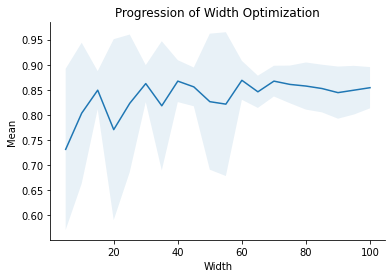

In [8]:
width_list = []
accuracy_means = []
accuracy_deviations = []

for i in range(5, 105, 5):
    width_list.append(i)
    accuracy = train_and_validate_model(i)
    accuracy_means.append(np.mean(accuracy))
    accuracy_deviations.append(np.std(accuracy))

summary_table = pd.DataFrame({"Width":width_list, "Mean":accuracy_means, "Std. dev.":accuracy_deviations})

# Plotting the results
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=summary_table, x="Width", y="Mean")
sns.despine()
plt.fill_between(summary_table['Width'], summary_table['Mean']+summary_table['Std. dev.'], summary_table['Mean']-summary_table['Std. dev.'], alpha=0.1)
plt.title("Progression of Width Optimization")